
# Bayesian Gaussian Mixture Model (GMM) in PyMC

This notebook simulates data from a 1D Gaussian mixture, fits a Bayesian GMM in PyMC (marginalizing over the latent labels), and visualizes posterior inferences and posterior predictive distributions.


## 1) Imports and data simulation

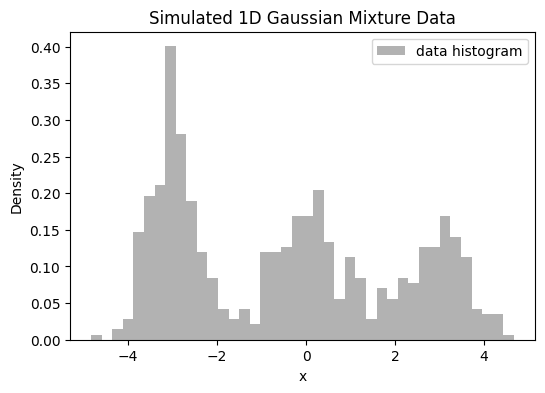

In [1]:
# %% Imports
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

RNG = np.random.default_rng(42)

# %% Simulate 1D mixture data
K = 3                              # number of components
n = 600                            # total sample size
w_true = np.array([0.4, 0.35, 0.25])
mu_true = np.array([-3.0, 0.0, 3.0])
sigma_true = np.array([0.5, 0.8, 0.7])

z_true = RNG.choice(K, size=n, p=w_true)
x = RNG.normal(mu_true[z_true], sigma_true[z_true])

# Visualize
plt.figure(figsize=(6, 4))
plt.hist(x, bins=40, density=True, alpha=0.6, color="gray", label="data histogram")
plt.title("Simulated 1D Gaussian Mixture Data")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


## 2) PyMC model

In [2]:
K = 3
with pm.Model(coords={"cluster": range(K)}) as gmm_1d:
    mu = pm.Normal(
        "mu", mu=0, sigma=5, dims="cluster",
        transform=pm.distributions.transforms.ordered,  # label-switching mitigation
        initval=np.linspace(-3, 3, K)
    )
    sigma = pm.HalfNormal("sigma", sigma=1.0, dims="cluster")
    w = pm.Dirichlet("w", a=np.ones(K), dims="cluster")

    y = pm.NormalMixture("y", w=w, mu=mu, sigma=sigma, observed=x)

    idata = pm.sample(1000, tune=1000, target_accept=0.9, chains=4, init="jitter+adapt_diag")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, w]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


## 3) Posterior summary (weights and means)

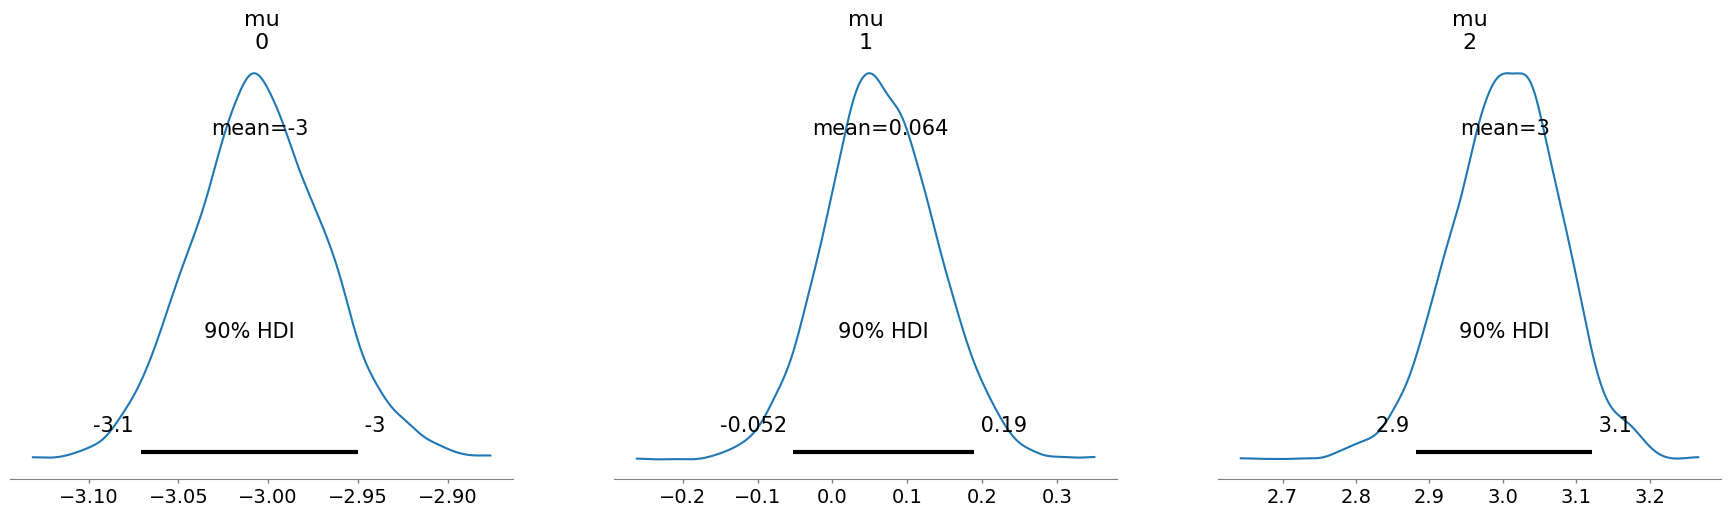

In [4]:
# Posterior summary
az.summary(idata, var_names=["w", "mu", "sigma"], round_to=2)

# Plot posterior distributions of component means
az.plot_posterior(idata, var_names=["mu"], hdi_prob=0.9)
plt.show()



# 4) Posterior predictive distribution

In [5]:
# Posterior predictive overlay (version-agnostic)
with gmm_1d:
    ppc = pm.sample_posterior_predictive(idata, var_names=["y"], random_seed=2025)

Sampling: [y]


Output()

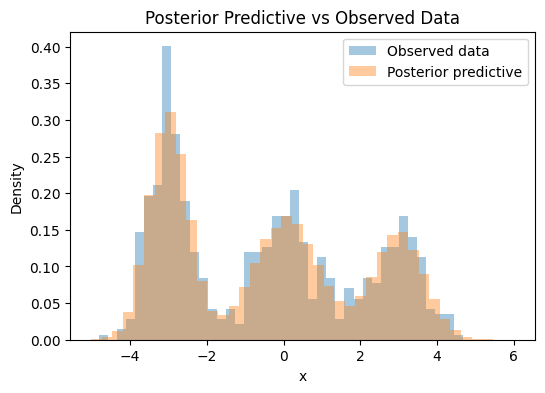

In [6]:
# Get a flat array of posterior predictive samples, robust across versions
# Newer PyMC/ArviZ: InferenceData with .posterior_predictive["y"]
da = ppc.posterior_predictive["y"]  # xarray.DataArray with dims like ('chain','draw','obs')
sample_dims = [d for d in ("chain", "draw") if d in da.dims]
# Subsample to avoid plotting millions of points
stacked = da.stack(sample=sample_dims)
S = stacked.sizes["sample"]
take = min(200, S)  # adjust if you want more/less
idx = np.random.default_rng(123).choice(S, size=take, replace=False)
y_flat = stacked.isel(sample=idx).values.ravel()


plt.figure(figsize=(6, 4))
plt.hist(x, bins=40, density=True, alpha=0.4, label="Observed data")
plt.hist(y_flat, bins=40, density=True, alpha=0.4, label="Posterior predictive")
plt.title("Posterior Predictive vs Observed Data")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()